In [1]:
from astropy.io import fits
from astropy.table import Table

from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt

import numpy as np

import pyvista as pv
from astropy.coordinates import SkyCoord

In [2]:
data, header = fits.getdata("data/perseus_3d_cutout.fits",header=True)

### Generate MeshGrid for Dust

In [3]:
arr_shape = data.shape
arr_shape

(90, 106, 129)

In [4]:
# increase the sampling, to four per voxel (every 0.25 of a voxel), instead of 1 per voxel
z_axis = np.arange(0,90,0.25)
y_axis = np.arange(0,106,0.25)
x_axis = np.arange(0,129,0.25)

In [5]:
zg, yg, xg = np.meshgrid(x_axis, y_axis, z_axis)

In [6]:
z_all = np.ravel(zg)
y_all = np.ravel(yg)
x_all = np.ravel(xg)

### Convert to world coords

In [7]:
w = WCS(header)
dust_coords = w.pixel_to_world(x_all, y_all, z_all)

keyword looks very much like CUNITia but isn't. [astropy.wcs.wcs]


In [8]:
dust_xyz = np.array((dust_coords[0].value,dust_coords[1].value,dust_coords[2].value))

## Create Ellipse From Deconvolution Data

In [9]:
results = Table.read("data/deconvolution_results.csv", format = "csv")

##### IC 348

In [10]:
center = (results['L'][0], results['B'][0], results['D'][0])

sigma_a = results['L_err'][0]
sigma_b = results['B_err'][0]
sigma_c = results['D_err'][0]

ic_ellipsoid = pv.ParametricEllipsoid(sigma_a, sigma_b, sigma_c, center=center)

ic_points = ic_ellipsoid.extract_geometry().points

ic = Table()
# add lbd values to table
ic['l']=ic_points[:,0]
ic['b']=ic_points[:,1]
ic['d']=ic_points[:,2]

c=SkyCoord(l=ic['l']*u.deg,b=ic['b']*u.deg,distance=ic['d']*u.pc, frame = "galactic")

# add xyz values to table
ic['x']=c.cartesian.x
ic['y']=c.cartesian.y
ic['z']=c.cartesian.z

##### NGC 1333

In [11]:
center = (results['L'][1], results['B'][1], results['D'][1])

sigma_a = results['L_err'][1]
sigma_b = results['B_err'][1]
sigma_c = results['D_err'][1]

ngc_ellipsoid = pv.ParametricEllipsoid(sigma_a, sigma_b, sigma_c, center=center)

ngc_points = ngc_ellipsoid.extract_geometry().points

ngc = Table()
# add lbd values to table
ngc['l']=ngc_points[:,0]
ngc['b']=ngc_points[:,1]
ngc['d']=ngc_points[:,2]

c=SkyCoord(l=ic['l']*u.deg,b=ic['b']*u.deg,distance=ic['d']*u.pc, frame = "galactic")

# add xyz values to table
ngc['x']=c.cartesian.x
ngc['y']=c.cartesian.y
ngc['z']=c.cartesian.z

## Creating Dust Mesh

##### converting dust to lbd coord

In [12]:
c = SkyCoord(u=dust_xyz[0]*u.pc,
             v=dust_xyz[1]*u.pc,
             w=dust_xyz[2]*u.pc, frame = "galactic", representation_type='cartesian')
dust_lbd = np.array((c.galactic.spherical.lon.value, 
                     c.galactic.spherical.lat.value, 
                     c.galactic.spherical.distance.value))

##### mesh

In [13]:
nodes = dust_lbd.T
mesh = pv.PolyData(nodes)

### IC 348 Selection

In [14]:
ic_selection = mesh.select_enclosed_points(ic_ellipsoid.extract_surface(),check_surface=False)

In [15]:
ic_bool_arr = ic_selection.point_arrays['SelectedPoints'].view(np.bool_)

In [16]:
# instead of extracting a 3D boolean array of the same shape as the original perseus cube, 
# we are going to instead grab the mask and use it to extract the x_all, y_all, and z_all 
# coordinates where mask = 1
ic_x_all_inmask = x_all[ic_bool_arr].astype(int)
ic_y_all_inmask = y_all[ic_bool_arr].astype(int)
ic_z_all_inmask = z_all[ic_bool_arr].astype(int)

#now we are going to make an array of zeros and fill points in ellipse with 1
ic_new_mask = np.zeros((data.shape))
ic_new_mask[ic_z_all_inmask,ic_y_all_inmask,ic_x_all_inmask] = 1

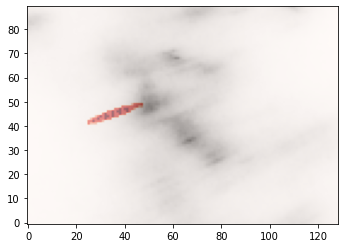

In [17]:
plt.imshow(np.sum(data, axis = 1),origin='lower',cmap='binary')
plt.imshow(np.sum(ic_new_mask, axis = 1),origin='lower',alpha=0.5,cmap='Reds');

##### write out mask

In [18]:
hdu = fits.PrimaryHDU(ic_new_mask)
hdu.writeto('perseus_ic348_mask_ellipse.fits',overwrite=True)

##### extract perseus data within ellipse

In [19]:
ic_mass = data[ic_z_all_inmask,ic_y_all_inmask,ic_x_all_inmask]

In [20]:
ic_mask = np.zeros((data.shape))
ic_mask[ic_z_all_inmask, ic_y_all_inmask, ic_x_all_inmask] = ic_mass

In [21]:
hdu = fits.PrimaryHDU(ic_mask)
hdu.header = header
hdu.writeto('data/perseus_ic348_only.fits',overwrite=True)

### NGC 1333 Selection

In [22]:
ngc_selection = mesh.select_enclosed_points(ngc_ellipsoid.extract_surface(),check_surface=False)

In [23]:
ngc_bool_arr = ngc_selection.point_arrays['SelectedPoints'].view(np.bool_)

In [24]:
ngc_x_all_inmask = x_all[ngc_bool_arr].astype(int)
ngc_y_all_inmask = y_all[ngc_bool_arr].astype(int)
ngc_z_all_inmask = z_all[ngc_bool_arr].astype(int)

ngc_new_mask = np.zeros((data.shape))
ngc_new_mask[ngc_z_all_inmask, ngc_y_all_inmask, ngc_x_all_inmask] = 1

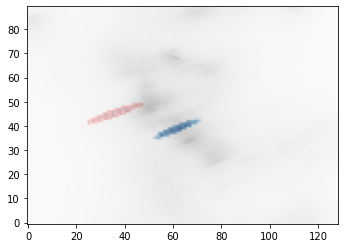

In [25]:
plt.imshow(np.sum(data, axis = 1),origin='lower',cmap='binary')
plt.imshow(np.sum(ic_new_mask, axis = 1),origin='lower',alpha=0.5,cmap='Reds')
plt.imshow(np.sum(ngc_new_mask, axis = 1),origin='lower',alpha=0.5,cmap='Blues');

##### write out mask

In [26]:
hdu = fits.PrimaryHDU(ngc_new_mask)
hdu.writeto('data/perseus_ngc1333_mask_ellipse.fits',overwrite=True)

##### extract perseus data within ellipse

In [27]:
ngc_mass = data[ngc_z_all_inmask, ngc_y_all_inmask, ngc_x_all_inmask]

In [28]:
ngc_mask = np.zeros((data.shape))
ngc_mask[ngc_z_all_inmask, ngc_y_all_inmask, ngc_x_all_inmask] = ngc_mass

In [29]:
hdu = fits.PrimaryHDU(ngc_mask)
hdu.header = header
hdu.writeto('data/perseus_ngc1333_only.fits',overwrite=True)

# See "4. dispersion_calculations.ipynb" for calculations of mass